In [2]:
!pip install datasets --quiet

In [4]:
from datasets import load_dataset
rag_dataset = load_dataset("neural-bridge/rag-dataset-12000")

since later we'll be performing a supervised task, we must also consider the test set

In [5]:
contexts = rag_dataset["train"]["context"] + rag_dataset["test"]["context"]

the choice here is to have a more meaningul semantic clustering based of sentence transformers rather that using tf-idf vectors

In [7]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

In [8]:
embeddings = model.encode(contexts, batch_size=64)

we are going to have 12k embeddings each of 384 dimension

In [9]:
embeddings.shape

(12000, 384)

we have chosen to not apply pca in order to not remove dimensions that might be meaningful to the semantics

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

here, we are finding the best value of k for the k-cluster based on a qualitative evaluation (silhouette score) to have more defined clusters

In [11]:
silhouette_scores = []
k_values = range(2, 50)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(embeddings)
    labels = kmeans.labels_
    score = silhouette_score(embeddings, labels)
    silhouette_scores.append(score)

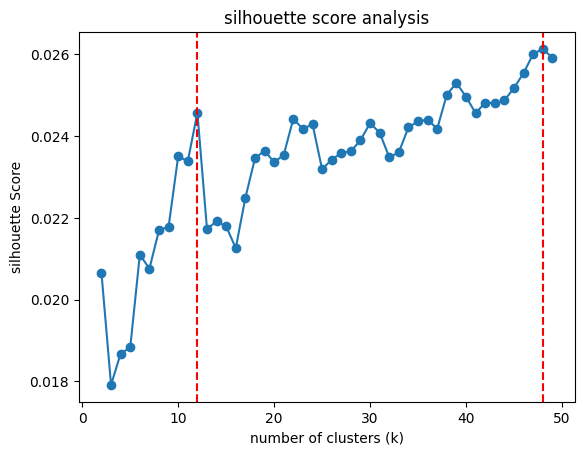

In [12]:
import matplotlib.pyplot as plt
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel("number of clusters (k)")
plt.ylabel("silhouette Score")
plt.title("silhouette score analysis")
plt.axvline(x=48, color='r', linestyle='--')
plt.axvline(x=12, color='r', linestyle='--')
plt.show()

very important trade-off: for the chosen range of k, the best value of k is 49. however, for a more interpretable clustering and an easire (manual) labeling, we are going to choose a smaller value of k (12) that has a slightly smaller silhouette score

In [13]:
best_k = 12
kmeans = KMeans(n_clusters=best_k, random_state=42).fit(embeddings)

how do we assign a label to each cluster? manually! and by choosing the most frequent words of each cluster

In [15]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

stop_words = list(text.ENGLISH_STOP_WORDS.union({"just", "new", "said", "use", "like"}))

df = pd.DataFrame({'text': contexts, 'cluster': kmeans.labels_})

for cluster_id in range(best_k):
    cluster_texts = df[df["cluster"] == cluster_id]["text"].tolist()
    tfidf = TfidfVectorizer(
        stop_words=stop_words,
        max_features=1000,  # focus on top 1000 terms per cluster
        max_df=0.9,         # ignore terms appearing in >90% of cluster docs
        min_df=2            # ignore terms appearing in <2 cluster docs
        )
    tfidf_matrix = tfidf.fit_transform(cluster_texts)
    feature_names = tfidf.get_feature_names_out()
    top_terms = np.argsort(np.asarray(tfidf_matrix.sum(axis=0)).flatten())[-15:][::-1]
    print(f"Cluster {cluster_id}: {[feature_names[i] for i in top_terms]}")

Cluster 0: ['business', 'company', 'data', 'time', 'information', 'year', 'people', 'online', 'market', 'website', 'marketing', 'services', 'make', 'service', 'site']
Cluster 1: ['food', 'time', 'good', 'add', 'make', 'restaurant', 'chicken', 'cheese', 'great', 'recipe', 'cup', 'chocolate', 'love', 'minutes', 'day']
Cluster 2: ['time', 'love', 'people', 'life', 'book', 'know', 'don', 'god', 'good', 'day', 'work', 've', 'way', 'think', 'things']
Cluster 3: ['hotel', 'home', 'room', 'property', 'time', 'city', 'house', 'free', 'service', 'area', 'business', 'great', 'make', 'best', 'day']
Cluster 4: ['students', 'school', 'university', 'work', 'program', 'time', 'education', 'year', 'people', 'information', 'student', 'research', 'help', 'children', 'college']
Cluster 5: ['music', 'film', 'time', 'movie', 'love', 'year', 'song', 'people', 'album', 'really', 'years', 'world', 'series', 'know', 'best']
Cluster 6: ['people', 'state', 'police', 'president', 'government', 'time', 'court', 'ye

the clusters seems reasonably clustered

In [16]:
cluster_labels = {
    0: "Business/Corporate",
    1: "Food/Culinary",
    2: "Literature/Philosophy",
    3: "Real Estate/Travel",
    4: "Education/Research",
    5: "Entertainment/Media",
    6: "Government/Legal",
    7: "Energy/Utilities",
    8: "Healthcare/Wellness",
    9: "Sports/Athletics",
    10: "Urban Planning/Public Works",
    11: "Art/Design"
}

given the dataset, we can now train classification models since we've successfully created labeled clusters! 😎

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

df = pd.DataFrame({'text': contexts, 'cluster': kmeans.labels_})

df['cluster'] = df['cluster'].map(cluster_labels)

X = df['text']
y = df['cluster']

vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=1000)
X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

                             precision    recall  f1-score   support

                 Art/Design       0.65      0.59      0.61       176
         Business/Corporate       0.66      0.74      0.70       307
         Education/Research       0.59      0.55      0.57       166
           Energy/Utilities       0.57      0.66      0.61       306
        Entertainment/Media       0.77      0.69      0.73       214
              Food/Culinary       0.74      0.63      0.68        94
           Government/Legal       0.62      0.64      0.63       213
        Healthcare/Wellness       0.75      0.63      0.69       172
      Literature/Philosophy       0.61      0.74      0.67       257
         Real Estate/Travel       0.66      0.58      0.62       144
           Sports/Athletics       0.84      0.83      0.83       142
Urban Planning/Public Works       0.57      0.46      0.51       209

                   accuracy                           0.65      2400
                  macro avg     

In [18]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train, y_train)

svm_y_pred = svm_model.predict(X_test)

print(classification_report(y_test, svm_y_pred))

                             precision    recall  f1-score   support

                 Art/Design       0.58      0.57      0.58       176
         Business/Corporate       0.65      0.74      0.69       307
         Education/Research       0.58      0.58      0.58       166
           Energy/Utilities       0.56      0.64      0.60       306
        Entertainment/Media       0.73      0.69      0.71       214
              Food/Culinary       0.73      0.63      0.67        94
           Government/Legal       0.62      0.60      0.61       213
        Healthcare/Wellness       0.75      0.65      0.69       172
      Literature/Philosophy       0.62      0.70      0.66       257
         Real Estate/Travel       0.64      0.58      0.61       144
           Sports/Athletics       0.87      0.82      0.85       142
Urban Planning/Public Works       0.57      0.45      0.51       209

                   accuracy                           0.64      2400
                  macro avg     

the results are not astonishing! and in a way - this is expected! many factors have to be considered: the fact that we have chosen dense instead of sparse vectors, the model used for the embedding, the value of k chosen, the algorithm used to chose it, the trade-off we made on it, the human labeling, etc.

**TO ADD: TRANSFORMERS X CLASSIFICATION**